In [1]:
import sys
sys.path.append("gpib_instrument_control")
import hp_3478a
import hp_8700_series_vna
import numpy as np
import time
import yig_controller_test
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]


yigControllerPort='/dev/ttyUSB0'
vna = hp_8700_series_vna.Hp8753A()
curMeter = hp_3478a.Hp3478A()
yc = yig_controller_test.YigController(yigControllerPort)

Waiting for init... Done


In [22]:
wr = np.arange(-32768, 32767, 128)
yigChs = range(6)

zeros = []
channels=[]
for c in yigChs:
    yc.yigA.set(c, wr[0])
    time.sleep(5);
    current=[]
    for w in wr:
        yc.yigA.set(c, w);
        #time.sleep(0.5)
        current.append(curMeter.readValue())
    channels.append(current)
    yc.yigA.set(6, 0)
    time.sleep(3)
    zeros.append(curMeter.readValue())
        


In [51]:
import scipy.io as sio
sio.savemat('yig_filter_driver_current_data.mat', {'zeros':zeros, 'channels':channels, 'wr':wr})

In [70]:
d=sio.loadmat('yig_filter_driver_current_data.mat')
zeros=d['zeros'][0]
channels=d['channels']
wr=d['wr'][0]

In [71]:
print(zeros)

[0.27262 0.27333 0.27344 0.27304 0.27293 0.27278]


Filter 0 has current from 0.012800 to 0.089150 [A] in control word range -21376 - 31360 [LSB]
Filter 1 has current from 0.024110 to 0.244400 [A] in control word range -22784 - 31360 [LSB]
Filter 2 has current from 0.027510 to 0.285500 [A] in control word range -22784 - 31360 [LSB]
Filter 3 has current from 0.051980 to 0.483470 [A] in control word range -23040 - 23424 [LSB]
Filter 4 has current from 0.095330 to 1.101560 [A] in control word range -23168 - 31360 [LSB]
Filter 5 has current from 0.096410 to 0.838890 [A] in control word range -23168 - 17280 [LSB]


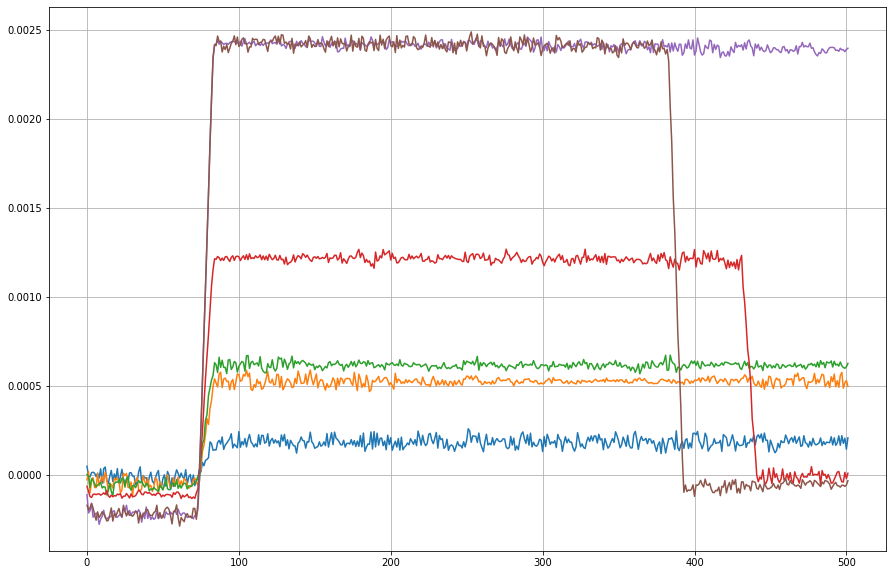

In [73]:
charr = np.array(channels)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

class FilterParameters:
    def __init__(self, lc, hc, lw, hw):
        self.lc=lc
        self.hc=hc
        self.lw=lw
        self.hw=hw

        
fParams=[]
for i in range(len(zeros)):
    avgd = moving_average(np.diff(charr[i,:]), 10)
    plt.plot(avgd)
    plt.grid(True)
    idxs = np.where(avgd>0.0002);
    mii=idxs[0][0]
    mai=idxs[0][-1]
    zc = zeros[i]
    mic=charr[i,mii]-zc
    mac=charr[i,mai]-zc
    #print(idxs[0])
    print("Filter %i has current from %f to %f [A] in control word range %d - %d [LSB]"%(i, mic, mac, wr[mii], wr[mai]))
    fParams.append(FilterParameters(mic, mac, wr[mii], wr[mai]))
    

In [ ]:
vna.setStartFrequency(130e6)
vna.setStopFrequency(20e9)
vna.setPoints(401)

fRanges=[]
for i in range(len(zeros)):
    print("Filter", i )
    fp = fParams[i]
    yc.switchA.set(i+1)
    yc.yigA.set(6, 0)
    fax = vna.frequencies()
    base = vna.readSParameter('S21')
    plt.plot(fax, 20*np.log10(np.abs(base)))
    sr = np.linspace(fp.lw, fp.hw, 8)
    freqs=[]
    
    for w in sr:
        yc.yigA.set(i, int(w))
        time.sleep(1)
        t = vna.readSParameter('S21')
        traces.append(t)
        delt = np.abs(t)/np.abs(base)
        freqs.append(fax[np.argmax(delt)])
        plt.plot(fax, 20*np.log10(delt))
    mif=np.min(freqs)
    maf=np.max(freqs)
    #print(freqs)
    print(np.diff(freqs))
    fRanges.append((mif, maf))
    
    plt.figure()

for fmi, fma in fRanges:
    print("%f to %f [GHz]"%(fmi/1e9, fma/1e9))

import scipy.io as sio
sio.savemat('yig_filter_driver_coarse_frequency.mat', {'fRanges':fRanges})

Filter 0
[4.96750e+07 9.93500e+07 1.98700e+08 1.49025e+08 1.98700e+08 1.98700e+08
 1.98700e+08]
Filter 1
[3.97400e+08 5.46425e+08 5.46425e+08 5.96100e+08 5.46425e+08 5.46425e+08
 5.46425e+08]
Filter 2
